# Stock market dynamics - Sentiment Analysis

Analyzing the News Headlines dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative. Based on this we predict if the stock will go up or down

#Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /home/vikram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#EDA

In [9]:
#Load the data
dataset = pd.read_csv(r"all-data.csv", encoding = 'latin-1')

In [10]:
dataset.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [11]:
dataset = dataset.rename(columns={'neutral':'Label','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'News'})

In [12]:
dataset.head()

,Label,News
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


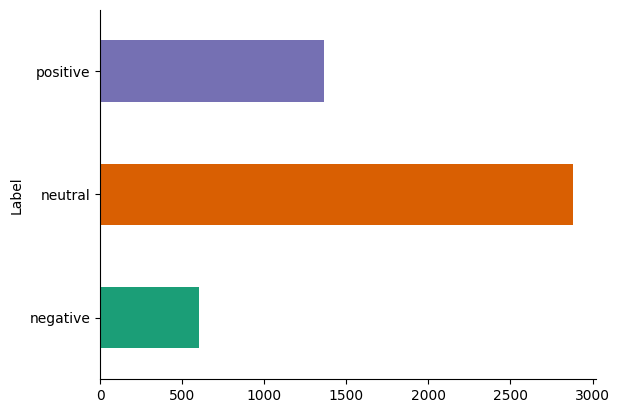

In [13]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
dataset.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
#Analyzing Label column
print(f"Label  count: \n{dataset['Label'].value_counts()}")

Label  count: 
Label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64


In [15]:
#Check for null values
dataset.isnull().sum()

Label    0
News     0
dtype: int64

In [16]:
# Convertng headlines to lower case
for index in range(len(dataset)): # Use range() to generate a sequence of numbers
    dataset.loc[index, 'News'] = dataset.loc[index, 'News'].lower() # Use .loc to access and modify cell value
dataset.head()

,Label,News
0,neutral,technopolis plans to develop in stages an area...
1,negative,the international electronic industry company ...
2,positive,with the new production plant the company woul...
3,positive,according to the company 's updated strategy f...
4,positive,financing of aspocomp 's growth aspocomp is ag...


In [17]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(dataset.News)

In [18]:
# Finding unique words in each news category
neg_news = " ".join([news for news in dataset[dataset['Label'] == 'negative']['News']])
neg_news = neg_news.lower().split()

pos_news = " ".join([news for news in dataset[dataset['Label'] == 'positive']['News']])
pos_news = pos_news.lower().split()

#Finding unique words in each label
unique_negative = [x for x in neg_news if x not in pos_news]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_news if x not in neg_news]
unique_positive = " ".join(unique_positive)


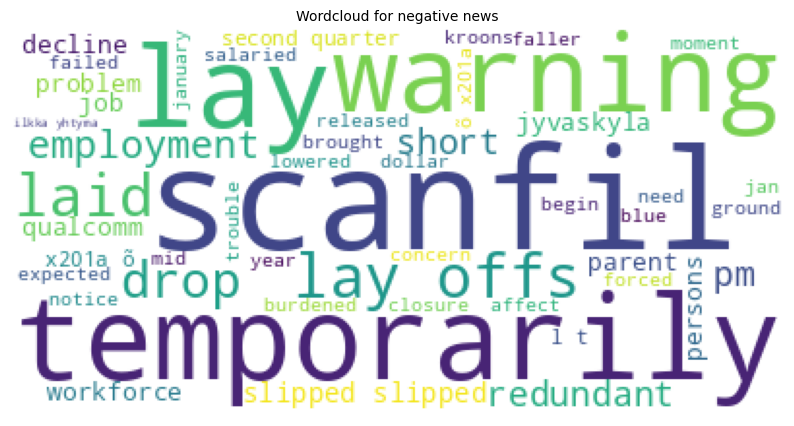

In [19]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative news', fontsize=10)
plt.axis('off')
plt.show()

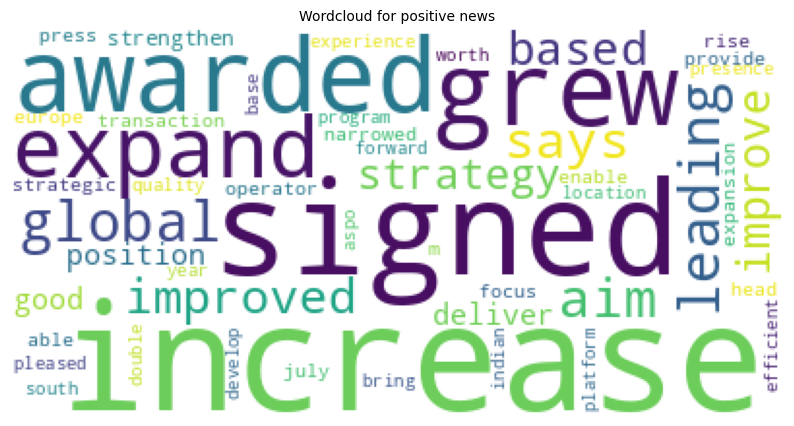

In [20]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive news', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling


In [21]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, dataset.shape[0]):
  # Access each headline using i as index
  news = re.sub('[^a-zA-Z]', ' ', dataset.iloc[i]['News'])
  news = news.lower().split()
  news = [stemmer.stem(word) for word in news if not word in STOPWORDS]
  news = ' '.join(news)
  corpus.append(news)

In [22]:
dataset['News'][0]

'technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'

In [23]:
corpus[0]

'technopoli plan develop stage area less squar meter order host compani work comput technolog telecommun statement said'

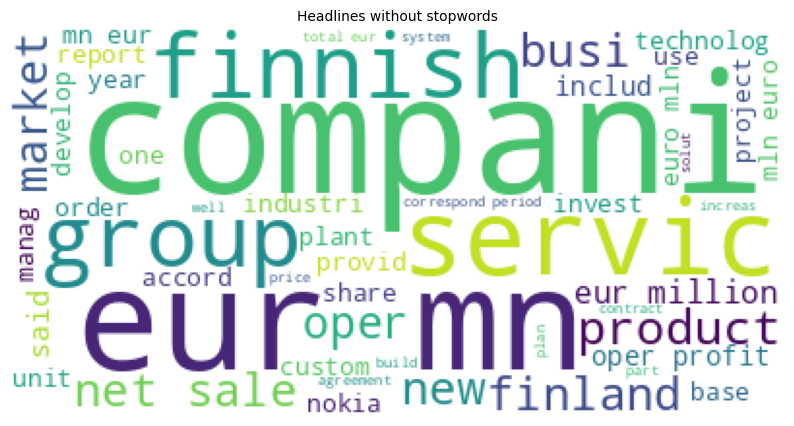

In [24]:
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

news = " ".join(corpus)
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(news))
plt.title('Headlines without stopwords', fontsize=10)
plt.axis('off')
plt.show()

In [25]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = dataset['Label'].values

In [26]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (4845, 2500)
y shape: (4845,)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (3391, 2500)
y train: (3391,)
X test: (1454, 2500)
y test: (1454,)


In [42]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [28]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
#Decision tree classifier
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

Random forest Validation

In [30]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train, y_train))
print("Testing Accuracy :", model_rf.score(X_test, y_test))

Training Accuracy : 0.9973459156590976
Testing Accuracy : 0.7558459422283357


In [31]:
#Predicting on the test set
y_preds = model_rf.predict(X_test)

In [32]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

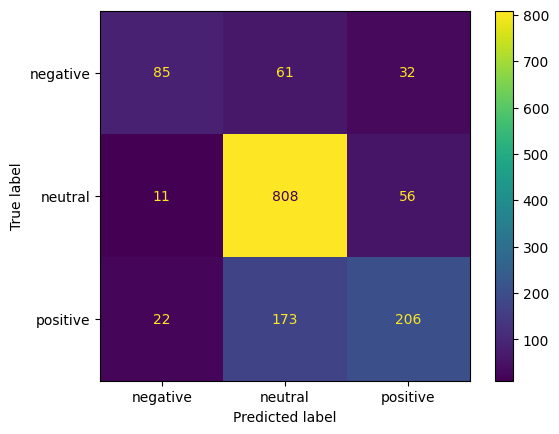

In [33]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [34]:
accuracies = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.7407886517438833
Standard Variance : 0.014090829338620143


Decision Tree Validation

In [35]:
print("Training Accuracy :", model_dt.score(X_train, y_train))
print("Testing Accuracy :", model_dt.score(X_test, y_test))

Training Accuracy : 0.9973459156590976
Testing Accuracy : 0.6691884456671252


In [36]:
y_preds = model_dt.predict(X_test)

In [37]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 87  48  43]
 [ 41 667 167]
 [ 41 141 219]]


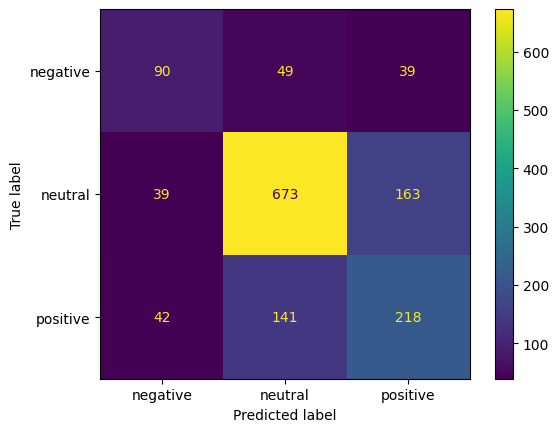

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

Hyperparameter tuning

In [38]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [39]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [ ]:
#Getting the best parameters from the grid search
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [ ]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

In [40]:
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [41]:
pickle.dump(model_rf, open('Models/model_rf.pkl', 'wb'))

In [43]:
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))